In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats

from collections import Counter
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from statistics import mean
from statistics import stdev
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [12]:
# Plotting

def make_confusion_matrix(model, threshold=0.5):
    """
    Predict class1 if probability of being in class 1 is greater than threshold
    """
    y_predict = (model.predict_proba(features_test_scaled_array)[:, 1] >= threshold)
    confusion = confusion_matrix(target_test_ser, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Rejected', 'Admitted'],
           yticklabels=['Rejected', 'Admitted']);
    plt.xlabel('Predicted')
    plt.ylabel('Observed')

In [3]:
# Import
physics_df = pd.read_csv('data/physics-ft-df.csv')
physics_df = physics_df.drop(columns = ["Unnamed: 0"])
print(physics_df.columns)

Index(['GPA', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing', 'GRE_Subject',
       'American', 'Papers', 'Research', 'Decision', 'GPA_rev',
       'GRE_Verbal_rev', 'GRE_Quantitative_rev', 'GRE_Writing_rev',
       'GRE_Subject_rev', 'Decision_rev', 'GPA_log', 'GRE_Verbal_log',
       'GRE_Quantitative_log', 'GRE_Writing_log', 'GRE_Subject_log', 'GPA_sq',
       'GRE_Verbal_sq', 'GRE_Quantitative_sq', 'GRE_Writing_sq',
       'GRE_Subject_sq', 'GRE_Verbal_pc', 'GRE_Quantitative_pc',
       'GRE_Writing_pc', 'GRE_Subject_pc', 'GREVxGREQ', 'GREVxGRES',
       'GREQxGRES', 'GREVxGREQxGRES'],
      dtype='object')


In [4]:
# Check if classes are balanced
normalized_target_counts = physics_df.Decision.value_counts(normalize=True) 
print(normalized_target_counts)

0    0.533483
1    0.466517
Name: Decision, dtype: float64


In [5]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
logreg_clf = LogisticRegression(C=1e9)
scaler = StandardScaler()
ros = RandomOverSampler(random_state=0)

In [6]:
# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(physics_df.drop(columns = ['Decision']), physics_df['Decision'], test_size=.2, random_state=42)

# Choose features
features_list = ['GPA', 'GPA_sq', 'GRE_Verbal', 'GRE_Quantitative', 'GRE_Writing_pc', 'GRE_Subject', 'GREVxGRES', 'American', 'Papers', 'Research']

features_train_chosen_df = features_train_all_df[features_list]
features_test_chosen_df = features_test_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
target_train_array = np.array(target_train_ser)

In [9]:
# KFold Cross-Validation with StandardScaler in the loop

# Collect the cross-validation results
cv_f1_list, roc_auc_list = [], []

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_resampled_array, target_train_cv_resampled_array = ros.fit_sample(features_train_cv_array, target_train_cv_array)
    features_train_cv_resampled_scaled_array = scaler.fit_transform(features_train_cv_resampled_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    logreg_clf.fit(features_train_cv_resampled_scaled_array, target_train_cv_resampled_array) # Fit model
    cv_f1_list.append(f1_score(logreg_clf.predict(features_val_cv_scaled_array), target_val_cv_array)) # Collect results
    roc_auc_list.append(roc_auc_score(target_val_cv_array, logreg_clf.predict_proba(features_val_cv_scaled_array)[:,1])) # Collect results

print('train_f1_score: ', mean(cv_f1_list),' +/- ', stdev(cv_f1_list))
print('train_roc_auc_score: ', mean(roc_auc_list),' +/- ', stdev(roc_auc_list))

train_f1_score:  0.5596858309606034  +/-  0.02008496016828599
train_roc_auc_score:  0.599475238280368  +/-  0.019688850571677814


In [10]:
# Final train and test

# Rebalance train features, no need to rebalance validation set, resample is better than smote
features_train_resampled_array, target_train_resampled_array = ros.fit_sample(features_train_chosen_array, target_train_array)
features_train_resampled_scaled_array = scaler.fit_transform(features_train_resampled_array) # Scale features
features_test_scaled_array = scaler.transform(features_test_chosen_df) # Scale features

logreg_clf.fit(features_train_resampled_scaled_array, target_train_resampled_array) # Fit model

print("test_f1_score = ", f1_score(logreg_clf.predict(features_test_scaled_array), target_test_ser))
print("test_roc_auc_score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))

test_f1_score =  0.5681528662420382
test_roc_auc_score =  0.6297283947529667


ROC AUC score =  0.6297283947529667


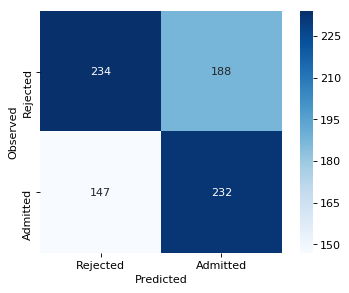

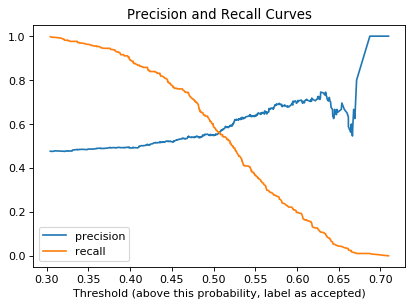

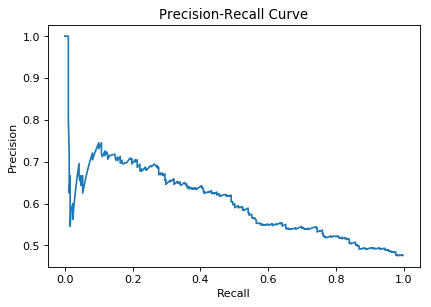

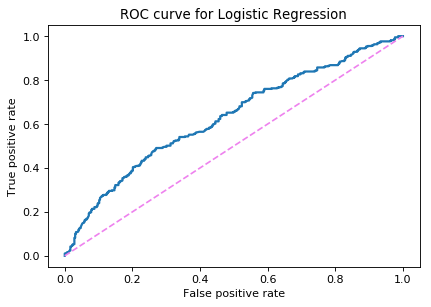

In [13]:
print("ROC AUC score = ", roc_auc_score(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1]))

# Confusion Matrix
make_confusion_matrix(logreg_clf, threshold=0.497)
plt.savefig("figures/feature-selection/confusion.png", transparent=True, bbox_inches="tight")

# Precision and recall curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlim(0, 1)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Fraction', fontsize=12)
plt.title('Precision and Recall Curves', fontsize=16)
plt.savefig("figures/feature-selection/precision-and-recall.png", transparent=True, bbox_inches="tight")

# Precision-recall curve
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=16)
plt.savefig("figures/feature-selection/precision-recall.png", transparent=True, bbox_inches="tight")

# ROC Curve
fpr, tpr, thresholds = roc_curve(target_test_ser, logreg_clf.predict_proba(features_test_scaled_array)[:,1])
plt.figure(dpi=80)
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC curve for Logistic Regression', fontsize=16)
plt.savefig("figures/feature-selection/roc.png", transparent=True, bbox_inches="tight")